<a href="https://colab.research.google.com/github/anaapbernardo/Bootcamp_DataScience/blob/main/Challenges_Bootcamp_Data_Science_Module_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import ShuffleSplit

from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import plot_roc_curve

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier

In [ ]:
# URL

sirio_libanes_dataset = 'https://github.com/anaapbernardo/Bootcamp_DataScience/blob/main/Files%20-%20Bootcamp%20Data%20Science/Kaggle_Sirio_Libanes_ICU_Prediction.xlsx?raw=true'

In [ ]:
df = pd.read_excel(sirio_libanes_dataset)
df

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
0,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
1,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.333333,-0.230769,-0.132075,-0.593220,0.535714,0.578947,0.333333,-0.230769,-0.132075,-0.586207,0.535714,0.578947,0.443299,0.0000,-0.025641,-0.500000,0.714286,0.838384,-0.076923,-0.459459,-0.313433,-0.636364,0.246377,0.578947,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,2-4,0
2,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4-6,0
3,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,-0.107143,0.736842,NaN,NaN,NaN,NaN,0.318681,0.898990,NaN,NaN,NaN,NaN,-0.275362,0.736842,NaN,NaN,NaN,NaN,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-1.000000,6-12,0
4,0,1,60th,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.000000,0.000000,0.000000,0.000000,-1.0,-0.871658,-0.871658,-0.871658,-0.871658,-1.0,-0.863874,-0.863874,-0.863874,-0.863874,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.414634,-0.414634,-0.414634,-0.414634,-1.0,-0.979069,-0.979069,...,-0.996762,-1.0,-0.243021,-0.338537,-0.213031,-0.317859,0.033779,0.665932,-0.283951,-0.376923,-0.188679,-0.379310,0.035714,0.631579,-0.340206,-0.4875,-0.572650,-0.857143,0.098901,0.797980,-0.076923,0.286486,0.298507,0.272727,0.362319,0.947368,-0.339130,0.325153,0.114504,0.176471,-0.238095,-0.818182,-0.389967,0.4075

## Exploratory Analysis

In [ ]:
def fill_table(df_original):
    cont_features_columns = df_original.iloc[:, 13:-2].columns
    cont_features = df_original.groupby('PATIENT_VISIT_IDENTIFIER', 
                                        as_index=False)[cont_features_columns]
    cont_features = cont_features.fillna(method='bfill').fillna(method='ffill')
    
    cat_features = df_original.iloc[:, :13]
    
    other_features = df_original.iloc[:, -2:]
    
    df_final = pd.concat([cat_features, cont_features, other_features], ignore_index=True,axis=1)
    df_final.columns = df_original.columns

    return df_final

In [ ]:
def prepare_window(rows):
    if(np.any(rows['ICU'])):
        rows.loc[rows['WINDOW']=='0-2', 'ICU'] = 1
    return rows.loc[rows['WINDOW'] == '0-2']

In [ ]:
# Filling table and removing rows of patients that went directly to ICU

df_clean = fill_table(df)
to_remove = df_clean.query('WINDOW=="0-2" and ICU==1')['PATIENT_VISIT_IDENTIFIER'].values
df_clean = df_clean.query('PATIENT_VISIT_IDENTIFIER not in @to_remove')

In [ ]:
# Drop NaN, grouping by patient visit, and setting age percentil as category

df_clean = df_clean.dropna()
df_clean = df_clean.groupby('PATIENT_VISIT_IDENTIFIER').apply(prepare_window)
df_clean['AGE_PERCENTIL'] = df_clean.AGE_PERCENTIL.astype('category').cat.codes
df_clean

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,0.086420,-0.230769,-0.283019,-0.586207,-0.285714,0.736842,0.237113,0.0000,-0.162393,-0.500000,0.208791,0.898990,-0.247863,-0.459459,-0.432836,-0.636364,-0.420290,0.736842,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.938950,-0.938950,...,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.506173,-0.815385,-0.056604,-0.517241,0.357143,0.947368,-0.525773,-0.5125,-0.111111,-0.714286,0.604396,0.959596,-0.435897,-0.491892,0.000000,-0.575758,0.101449,1.000000,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.515528,-0.351328,-0.747001,-0.756272,-1.000000,-0.961262,0-2,1
3,15,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-0.263158,-0.263158,-0.263158,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.972789,-0.972789,...,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,0.012346,-0.369231,-0.528302,-0.448276,-0.285714,0.684211,0.175258,-0.1125,-0.384615,-0.357143,0.208791,0.878788,-0.299145,-0.556757,-0.626866,-0.515152,-0.420290,0.684211,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,0.605263,0.605263,0.605263,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.000000,-1.000000,-1.000000,-1.000000,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.317073,-0.317073,-0.317073,-0.317073,-1.0,-0.935113,-0.935113,...,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,0.333333,-0.153846,0.160377,-0.586207,0.285714,0.868421,0.443299,0.0000,0.196581,-0.571429,0.538462,0.939394,-0

In [ ]:
# Dummy Classifier

np.random.seed(73246)

x_columns = df.columns
y = df_clean['ICU']
x = df_clean[x_columns].drop(['ICU','WINDOW'], axis=1)
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)
model = DummyClassifier()
model.fit(x_train, y_train)

y_prediction = model.predict(x_test)
accuracy_score(y_test, y_prediction)

/usr/local/lib/python3.7/dist-packages/sklearn/dummy.py:132: FutureWarning: The default value of strategy will change from stratified to prior in 0.24.
  "stratified to prior in 0.24.", FutureWarning)


0.48863636363636365

In [ ]:
# Logistic Regression

model_log_regression = LogisticRegression(max_iter=10000)
model_log_regression.fit(x_train, y_train)

y_prediction = model_log_regression.predict(x_test)
accuracy_score(y_test, y_prediction)

0.6818181818181818

In [ ]:
df_clean.describe()

,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_MEAN,ALBUMIN_MIN,ALBUMIN_MAX,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_MEAN,BE_ARTERIAL_MIN,BE_ARTERIAL_MAX,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_MEAN,BE_VENOUS_MIN,BE_VENOUS_MAX,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_MEAN,BIC_ARTERIAL_MIN,BIC_ARTERIAL_MAX,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_MEAN,BIC_VENOUS_MIN,BIC_VENOUS_MAX,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_MEAN,...,DIMER_MIN,DIMER_MAX,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,BLOODPRESSURE_DIASTOLIC_MEDIAN,BLOODPRESSURE_SISTOLIC_MEDIAN,HEART_RATE_MEDIAN,RESPIRATORY_RATE_MEDIAN,TEMPERATURE_MEDIAN,OXYGEN_SATURATION_MEDIAN,BLOODPRESSURE_DIASTOLIC_MIN,BLOODPRESSURE_SISTOLIC_MIN,HEART_RATE_MIN,RESPIRATORY_RATE_MIN,TEMPERATURE_MIN,OXYGEN_SATURATION_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_SISTOLIC_MAX,HEART_RATE_MAX,RESPIRATORY_RATE_MAX,TEMPERATURE_MAX,OXYGEN_SATURATION_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,BLOODPRESSURE_DIASTOLIC_DIFF_REL,BLOODPRESSURE_SISTOLIC_DIFF_REL,HEART_RATE_DIFF_REL,RESPIRATORY_RATE_DIFF_REL,TEMPERATURE_DIFF_REL,OXYGEN_SATURATION_DIFF_REL,ICU
count,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.0,352.000000,352.000000,352.000000,352.000000,352.0,352.000000,352.000000,352.000000,352.000000,352.0,352.000000,352.000000,352.000000,352.000000,352.0,352.000000,352.000000,352.000000,352.000000,352.0,352.000000,352.000000,...,352.000000,352.000000,352.0,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000,352.000000
mean,192.818182,0.457386,4.278409,0.380682,0.105114,0.022727,0.090909,0.019886,0.127841,0.042614,0.193182,0.161932,0.832386,0.576854,0.576854,0.576854,0.576854,-1.0,-0.997843,-0.997843,-0.997843,-0.997843,-1.0,-0.958383,-0.958383,-0.958383,-0.958383,-1.0,-0.318320,-0.318320,-0.318320,-0.318320,-1.0,-0.320261,-0.320261,-0.320261,-0.320261,-1.0,-0.945688,-0.945688,...,-0.955163,-0.955163,-1.0,-0.037918,-0.313418,-0.241400,-0.466596,0.109091,0.752578,-0.039036,-0.314467,-0.240459,-0.454741,0.107194,0.753962,0.108306,-0.087145,-0.143454,-0.390422,0.436876,0.896981,-0.313228,-0.500338,-0.383904,-0.504304,-0.077157,0.769737,-0.957856,-0.960855,-0.966863,-0.962066,-0.965233,-0.985365,-0.963091,-0.958921,-0.976421,-0.964390,-0.965725,-0.985390,0.463068
std,110.763735,0.498890,2.886611,0.486246,0.307136,0.149245,0.287889,0.139809,0.334388,0.202272,0.395356,0.368913,0.374055,0.134550,0.134550,0.134550,0.134550,0.0,0.024345,0.024345,0.024345,0.024345,0.0,0.114628,0.114628,0.114628,0.114628,0.0,0.032392,0.032392,0.032392,0.032392,0.0,0.089648,0.089648,0.089648,0.089648,0.0,0.044260,0.044260,...,0.142000,0.142000,0.0,0.265020,0.293299,0.278051,0.221957,0.269461,0.156628,0.269149,0.294161,0.285713,0.235012,0.275171,0.161405,0.235462,0.246015,0.252937,0.233023,0.165714,0.062834,0.186318,0.211692,0.225000,0.209839,0.229507,0.159424,0.111052,0.113712,0.095011,0.110411,0.086132,0.032640,0.106132,0.117561,0.059606,0.095115,0.084306,0.033025,0.499344
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.578947,-0.578947,-0.578947,-0.578947,-1.0,-1.000000,-1.000

### Challenge 01: Use another method to transform the 'AGE_PERCENTIL' as a category type

In [ ]:
df.AGE_PERCENTIL.unique()

array(['60th', '90th', '10th', '40th', '70th', '20th', '50th', '80th',
       '30th', 'Above 90th'], dtype=object)

In [ ]:
age_percentil_dict = {'10th': 0,
                      '20th': 1,
                      '30th': 2,
                      '40th': 3,
                      '50th': 4,
                      '60th': 5,
                      '70th': 6,
                      '80th': 7,
                      '90th': 8,
                      'Above 90th': 9
                      }

In [ ]:
df['AGE_PERCENTIL'].map(age_percentil_dict).astype('category')

0       5
1       5
2       5
3       5
4       5
       ..
1920    4
1921    4
1922    4
1923    4
1924    4
Name: AGE_PERCENTIL, Length: 1925, dtype: category
Categories (10, int64): [0, 1, 2, 3, ..., 6, 7, 8, 9]

## Evaluation Metrics

In [ ]:
model_tree = DecisionTreeClassifier()
model_tree.fit(x_train, y_train)
prediction_tree = model_tree.predict(x_test)
accuracy_score(y_test, prediction_tree)

0.6590909090909091

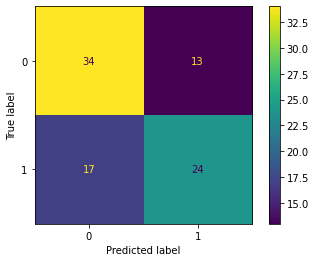

In [ ]:
plot_confusion_matrix(model_tree, x_test, y_test)

In [ ]:
TruePositive = 24
TrueNegative = 34
FalsePositive = 13
FalseNegative = 17

In [ ]:
report_tree = classification_report(y_test, prediction_tree)
print(report_tree)

              precision    recall  f1-score   support

           0       0.67      0.72      0.69        47
           1       0.65      0.59      0.62        41

    accuracy                           0.66        88
   macro avg       0.66      0.65      0.65        88
weighted avg       0.66      0.66      0.66        88



### Challenge 02: Search about f1-score

The F1 is the weighted average of precision and recall. Its best value is 1 and the worst is 0. 

F1 score is calculated by the following equation:

$F1 = 2 * \frac{(Precision * Recall)}{(Precision + Recall)}$

F1 score is an important measure when a balance between Precision and Recall is needed.

<font size=2> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html

<font size=2> https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9 

### Challenge 03: Search and plot the Decision Tree created by the model

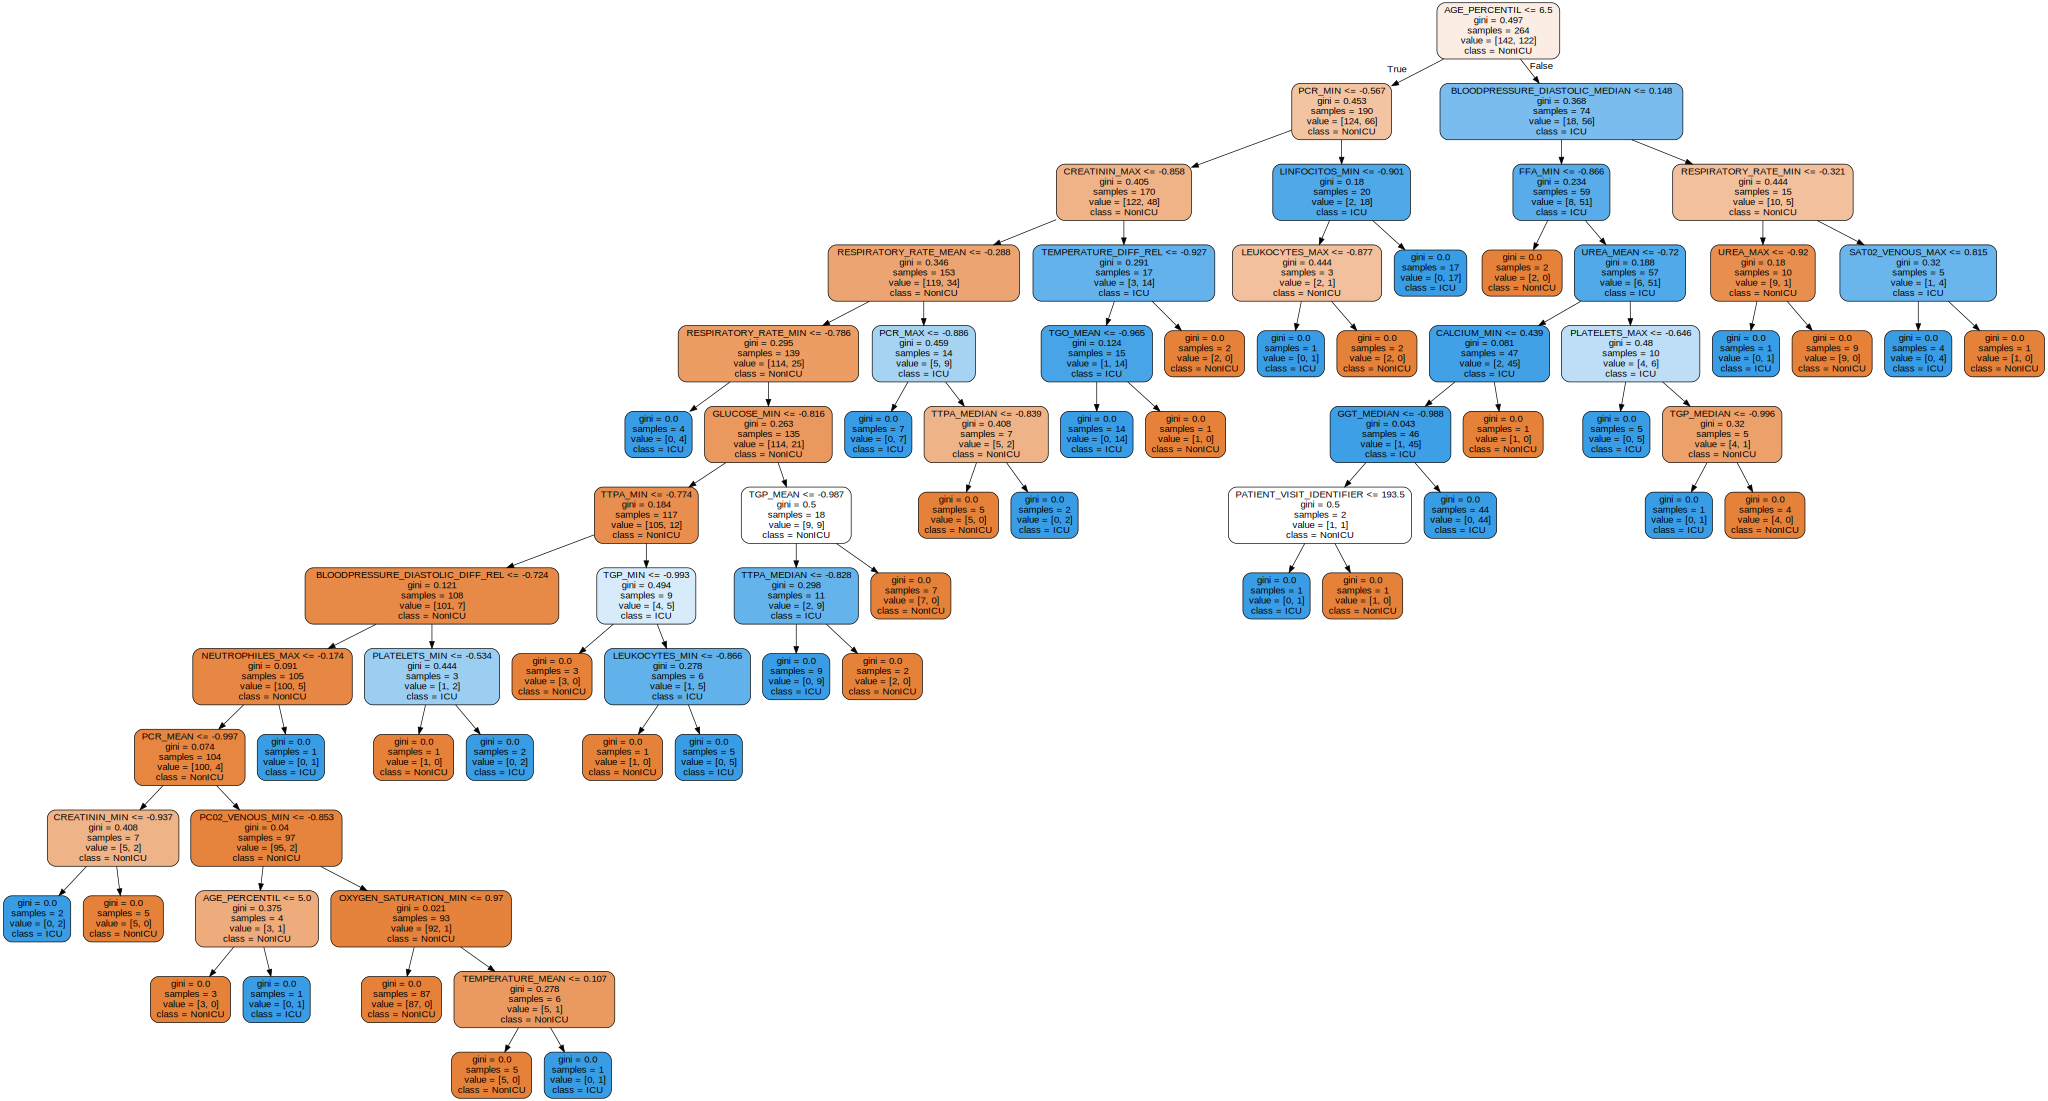

In [ ]:
model_tree.fit(x_train, y_train)
features = x_train.columns

decision_tree = export_graphviz(model_tree, out_file=None, filled=True, rounded=True,
                            class_names=['NonICU', 'ICU'],
                            feature_names=features)

graph = graphviz.Source(decision_tree)
graph

## ROC curve and AUC

In [ ]:
prob_tree = model_tree.predict_proba(x_test)
roc_auc_score(y_test, prob_tree[:, 1])

0.6437467566165024

In [ ]:
def run_model(model, data):

    x_columns = data.columns
    y = data['ICU']
    x = data[x_columns].drop(['ICU','WINDOW'], axis=1)
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)

    model.fit(x_train, y_train)
    predict = model.predict(x_test)
    prob_predict = model.predict_proba(x_test)

    auc = roc_auc_score(y_test, prob_predict[:,1])

    print(f'AUC {auc}')
    print('\nClassification Report')
    print(classification_report(y_test, predict))

In [ ]:
run_model(model_tree, df_clean)

AUC 0.5659055526725479

Classification Report
              precision    recall  f1-score   support

           0       0.58      0.77      0.66        47
           1       0.58      0.37      0.45        41

    accuracy                           0.58        88
   macro avg       0.58      0.57      0.55        88
weighted avg       0.58      0.58      0.56        88



In [ ]:
run_model(model_log_regression, df_clean)

AUC 0.7410482615464452

Classification Report
              precision    recall  f1-score   support

           0       0.64      0.81      0.72        47
           1       0.69      0.49      0.57        41

    accuracy                           0.66        88
   macro avg       0.67      0.65      0.64        88
weighted avg       0.67      0.66      0.65        88



### Challenge 04: Plot the ROC curve

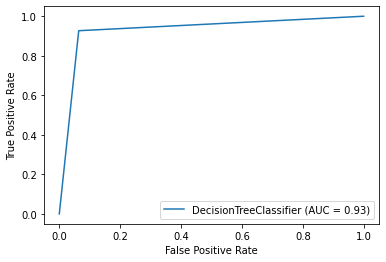

In [ ]:
plot_roc_curve(model_tree, x_test, y_test)
plt.show()

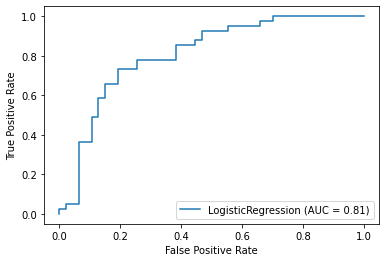

In [ ]:
plot_roc_curve(model_log_regression, x_test, y_test)
plt.show()

## Effects of Randomness

Running the models and measuring the AUC average makes the results more reliable.

In [ ]:
def run_n_models(model, data, n):

    x_columns = data.columns
    y = data['ICU']
    x = data[x_columns].drop(['ICU','WINDOW'], axis=1)
    
    auc_list = []

    for _ in range(n):
      x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y)
      model.fit(x_train, y_train)
      prob_predict = model.predict_proba(x_test)
      auc = roc_auc_score(y_test, prob_predict[:,1])
      auc_list.append(auc)

    auc_avg = np.mean(auc_list)
    auc_std = np.std(auc_list)

    print(f'AUC {auc_avg}')
    print(f'Interval {auc_avg - 2*auc_std} - {auc_avg + 2*auc_std}') 

In [ ]:
run_n_models(model_tree, df_clean, 50)

AUC 0.6309289050337312
Interval 0.5351693321456963 - 0.7266884779217662


In [ ]:
run_n_models(model_log_regression, df_clean, 50)

AUC 0.7515412558380902
Interval 0.672426188076034 - 0.8306563236001463


### Challenge 05: Read the sklearn documentation and test other models

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html#sklearn.ensemble.GradientBoostingClassifier

In [ ]:
#Gradient Boosting Classifier

model_gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
                                       max_depth=1, random_state=54765)
model_gbc.fit(x_train, y_train)
model_gbc.score(x_test, y_test)

0.7045454545454546

In [ ]:
predict_gbc = model_gbc.predict(x_test)
prob_predict_gbc = model_gbc.predict_proba(x_test)
auc_gbc = roc_auc_score(y_test, prob_predict_gbc[:,1])

print(f'AUC {auc_gbc}')
print('\nClassification Report')
print(classification_report(y_test, predict_gbc))

AUC 0.7176959003632589

Classification Report
              precision    recall  f1-score   support

           0       0.72      0.72      0.72        47
           1       0.68      0.68      0.68        41

    accuracy                           0.70        88
   macro avg       0.70      0.70      0.70        88
weighted avg       0.70      0.70      0.70        88



## Cross-Validation

In [ ]:
cv = StratifiedKFold(n_splits=5, shuffle=True)
cross_validate(model_log_regression, x, y, cv=cv)

{'fit_time': array([0.18957114, 0.57866406, 0.56968999, 0.58447099, 0.21995425]),
 'score_time': array([0.00218439, 0.00222564, 0.00212836, 0.00213695, 0.00211906]),
 'test_score': array([0.70422535, 0.74647887, 0.71428571, 0.65714286, 0.74285714])}

In [ ]:
cross_validate(model_tree, x, y, cv=cv)

{'fit_time': array([0.03225183, 0.02599478, 0.02555227, 0.02648401, 0.01919985]),
 'score_time': array([0.00195718, 0.00186253, 0.00183606, 0.001297  , 0.00123096]),
 'test_score': array([0.69014085, 0.64788732, 0.68571429, 0.6       , 0.72857143])}

In [ ]:
cv_rep = RepeatedStratifiedKFold(n_splits=5, n_repeats=10)
cross_validate(model_log_regression, x, y, cv=cv_rep)

{'fit_time': array([0.72566772, 0.53398848, 0.66790318, 0.5632329 , 0.12803054,
        0.53695655, 0.57806468, 0.2506237 , 0.60551739, 0.19028497,
        0.23536706, 0.58260369, 0.29421186, 0.71357536, 0.52535105,
        0.21108294, 0.55724692, 0.58624268, 0.24657345, 0.65684509,
        0.1964016 , 0.58467793, 0.59604192, 0.61243081, 0.18723536,
        0.61086178, 0.58899045, 0.65544653, 0.6006875 , 0.61216259,
        0.41973948, 0.65493369, 0.2428863 , 0.53664827, 0.2461071 ,
        0.52325988, 0.62069225, 0.66305447, 0.46772885, 0.57674193,
        0.25989676, 0.59603477, 0.53192592, 0.5619328 , 0.22390628,
        0.57929325, 0.26320004, 0.61672425, 0.23102832, 0.53607059]),
 'score_time': array([0.00213957, 0.00211596, 0.0021379 , 0.00213337, 0.00202322,
        0.00211215, 0.00320911, 0.00210571, 0.00211263, 0.00212145,
        0.00205779, 0.00214028, 0.00209641, 0.00212049, 0.00216222,
        0.00209641, 0.00214171, 0.00214005, 0.00204062, 0.00212908,
        0.00208831, 

In [ ]:
def run_model_cv(ml_model, data, n_splits, n_repeats):

    np.random.seed(1231234)
    data = data.sample(frac=1).reset_index(drop=True)
    x_columns = data.columns
    y = data['ICU']
    x = data[x_columns].drop(['ICU','WINDOW'], axis=1)
    
    
    cv = RepeatedStratifiedKFold(n_splits=n_splits, n_repeats=n_repeats)
    results=cross_validate(ml_model, x, y, cv=cv, scoring='roc_auc')
    
    auc_medio = np.mean(results['test_score'])
    auc_std = np.std(results['test_score'])
 
    print(f'AUC {auc_medio}'
          f'\n Interval {auc_medio-(2*auc_std)} - {auc_medio +(2*auc_std)}')

In [ ]:
run_model_cv(model_log_regression, df_clean, 5, 10)

AUC 0.757641695223932
 Interval 0.6355431542339184 - 0.8797402362139456


In [ ]:
run_n_models(model_log_regression, df_clean, 50)

AUC 0.7615672029060715
Interval 0.65404852218462 - 0.869085883627523


### Challenge 06: Test another splitter class

https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit

In [ ]:
# Shuffle Split

cv_ss = ShuffleSplit(n_splits=5, test_size=0.25, random_state=4352)
cross_validate(model_log_regression, x, y, cv=cv_ss)

{'fit_time': array([0.53811765, 0.20077753, 0.20509386, 0.66384912, 0.57944226]),
 'score_time': array([0.00214052, 0.00213194, 0.00214505, 0.00215483, 0.00215554]),
 'test_score': array([0.68181818, 0.65909091, 0.67045455, 0.70454545, 0.73863636])}

## Overfit and Random Forest

In [ ]:
def run_model_auc(ml_model, data, n_splits, n_repeats):

    np.random.seed(1231234)
    data = data.sample(frac=1).reset_index(drop=True)
    x_columns = data.columns
    y = data["ICU"]
    x = data[x_columns].drop(["ICU","WINDOW"], axis=1)
    
    
    cv = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats=n_repeats)
    results=cross_validate(ml_model, x, y, cv=cv, scoring='roc_auc', return_train_score=True)
    
    auc_mean = np.mean(results['test_score'])
    auc_mean_train = np.mean(results['train_score'])
    
    print(f'AUC  {auc_mean} - {auc_mean_train}')
    return auc_mean, auc_mean_train

In [ ]:
# Decision Tree Classifier

test_list = []
train_list = []

for i in range(1,15):
    model_tree = DecisionTreeClassifier(max_depth=i)
    test, train = run_model_auc(model_tree, df_clean, 5, 10)
    test_list.append(test)
    train_list.append(train)

AUC  0.5755830262080263 - 0.6445982993536308
AUC  0.6544700741411268 - 0.75415524801741
AUC  0.6643847795163584 - 0.8243714304989842
AUC  0.6554932930837536 - 0.8832038893699776
AUC  0.6475058192163456 - 0.9275331115338461
AUC  0.6239047951959137 - 0.9567921210944048
AUC  0.6117738776455882 - 0.9745102329260463
AUC  0.5987671815056683 - 0.9855938255169409
AUC  0.5877544694814432 - 0.991376822665679
AUC  0.5917582923832925 - 0.9946888385564852
AUC  0.6009579413444545 - 0.9970452758822465
AUC  0.6147261533363507 - 0.9986297665919551
AUC  0.6212348996723998 - 0.9994661199548005
AUC  0.6256292095025647 - 0.9998695491440995


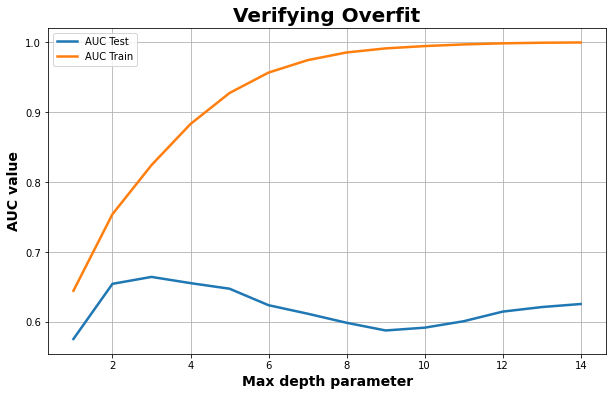

In [ ]:
x = range(1,15)

plt.figure(figsize=(10,6))

plt.plot(x, test_list, label='AUC Test', linewidth=2.5)
plt.plot(x, train_list, label='AUC Train', linewidth=2.5)

plt.title('Verifying Overfit', fontsize=20, fontweight='bold')
plt.legend()

plt.xlabel('Max depth parameter', fontsize=14, fontweight='bold')
plt.ylabel('AUC value', fontsize=14, fontweight='bold')

plt.grid()
plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.rcParams['figure.facecolor'] = 'white'

plt.show()

In [ ]:
# Random Forest

test_list = []
train_list = []

for i in range(1,15):
    model_forest = RandomForestClassifier(max_depth=i)
    test, train = run_model_auc(model_forest, df_clean, 5, 10)
    test_list.append(test)
    train_list.append(train)

AUC  0.7754785968683994 - 0.8549995635150238
AUC  0.7868632672744513 - 0.8976687127896622
AUC  0.7931550390103022 - 0.9403124842531797
AUC  0.7983565832578993 - 0.9709123570096604
AUC  0.7990938591103065 - 0.98788117359786
AUC  0.8004527808310704 - 0.9959760554693325
AUC  0.7994808369972844 - 0.9990287365273224
AUC  0.7977776116427432 - 0.9998630161707951
AUC  0.7963008103797579 - 0.9999847540078024
AUC  0.7927381904931247 - 1.0
AUC  0.7928442699577567 - 1.0
AUC  0.7923345025647657 - 1.0
AUC  0.7939161507500323 - 1.0
AUC  0.7939437314108367 - 1.0


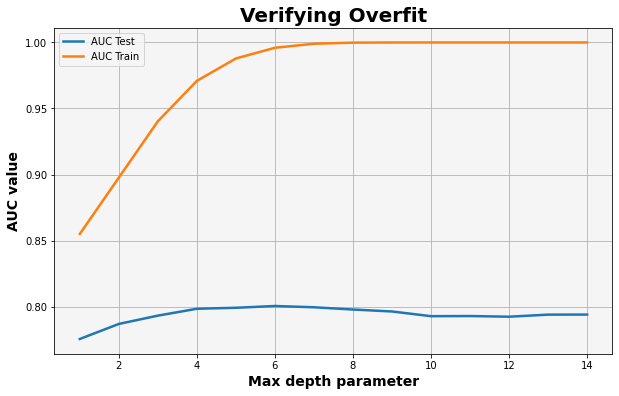

In [ ]:
x = range(1,15)
plt.figure(figsize=(10,6))

plt.plot(x, test_list, label='AUC Test', linewidth=2.5)
plt.plot(x, train_list, label='AUC Train', linewidth=2.5)

plt.title('Verifying Overfit', fontsize=20, fontweight='bold')
plt.legend()

plt.xlabel('Max depth parameter', fontsize=14, fontweight='bold')
plt.ylabel('AUC value', fontsize=14, fontweight='bold')

plt.grid()
plt.rcParams['axes.facecolor'] = 'whitesmoke'
plt.rcParams['figure.facecolor'] = 'white'

plt.show()

In [ ]:
model_forest = RandomForestClassifier(n_estimators=10)
test, train = run_model_auc(model_forest, df_clean, 5, 10)

AUC  0.7428159147484805 - 0.999444041300827


In [ ]:
model_forest = RandomForestClassifier(n_estimators=100)
test, train = run_model_auc(model_forest, df_clean, 5, 10)

AUC  0.7939557739557739 - 1.0


In [ ]:
model_forest = RandomForestClassifier(n_estimators=200)
test, train = run_model_auc(model_forest, df_clean, 5, 10)

AUC  0.7950421219664641 - 1.0


### Challenge 07: Read about Overfit and Underfit

https://towardsdatascience.com/what-are-overfitting-and-underfitting-in-machine-learning-a96b30864690

https://machinelearningmastery.com/overfitting-and-underfitting-with-machine-learning-algorithms/

https://datascience.foundation/sciencewhitepaper/underfitting-and-overfitting-in-machine-learning

### Challenge 08: Choose a ML model and study its hyperparameters

https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html

https://scikit-learn.org/stable/modules/ensemble.html#forest

## Validation

In [ ]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 352 entries, (0, 0) to (384, 1920)
Columns: 231 entries, PATIENT_VISIT_IDENTIFIER to ICU
dtypes: float64(225), int64(4), int8(1), object(1)
memory usage: 659.8+ KB


In [ ]:
df_clean.select_dtypes(exclude='float64')

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,
0,0,0,1,5,0,0-2,1
2,10,2,0,0,0,0-2,1
3,15,3,0,3,1,0-2,0
4,20,4,0,0,0,0-2,0
5,25,5,0,0,0,0-2,0
...,...,...,...,...,...,...,...
380,1900,380,0,3,1,0-2,1
381,1905,381,1,9,0,0-2,0
382,1910,382,0,4,0,0-2,1


In [ ]:
def remove_corr_var(data, high_corr):

    matrix_corr = data.iloc[:,4:-2].corr().abs()
    matrix_upper = matrix_corr.where(np.triu(np.ones(matrix_corr.shape), k=1).astype(np.bool))
    exclude = [column for column in matrix_upper.columns if any(matrix_upper[column] > high_corr)]

    return data.drop(exclude, axis=1)

In [ ]:
df_clean_no_corr = remove_corr_var(df_clean, 0.95)
df_clean_no_corr

,,PATIENT_VISIT_IDENTIFIER,AGE_ABOVE65,AGE_PERCENTIL,GENDER,DISEASE GROUPING 1,DISEASE GROUPING 2,DISEASE GROUPING 3,DISEASE GROUPING 4,DISEASE GROUPING 5,DISEASE GROUPING 6,HTN,IMMUNOCOMPROMISED,OTHER,ALBUMIN_MEDIAN,ALBUMIN_DIFF,BE_ARTERIAL_MEDIAN,BE_ARTERIAL_DIFF,BE_VENOUS_MEDIAN,BE_VENOUS_DIFF,BIC_ARTERIAL_MEDIAN,BIC_ARTERIAL_DIFF,BIC_VENOUS_MEDIAN,BIC_VENOUS_DIFF,BILLIRUBIN_MEDIAN,BILLIRUBIN_DIFF,BLAST_MEDIAN,BLAST_DIFF,CALCIUM_MEDIAN,CALCIUM_DIFF,CREATININ_MEDIAN,CREATININ_DIFF,FFA_MEDIAN,FFA_DIFF,GGT_MEDIAN,GGT_DIFF,GLUCOSE_MEDIAN,GLUCOSE_DIFF,HEMATOCRITE_MEDIAN,HEMATOCRITE_DIFF,HEMOGLOBIN_DIFF,...,PH_ARTERIAL_DIFF,PH_VENOUS_MEDIAN,PH_VENOUS_DIFF,PLATELETS_MEDIAN,PLATELETS_DIFF,POTASSIUM_MEDIAN,POTASSIUM_DIFF,SAT02_ARTERIAL_MEDIAN,SAT02_ARTERIAL_DIFF,SAT02_VENOUS_MEDIAN,SAT02_VENOUS_DIFF,SODIUM_MEDIAN,SODIUM_DIFF,TGO_MEDIAN,TGO_DIFF,TGP_MEDIAN,TGP_DIFF,TTPA_MEDIAN,TTPA_DIFF,UREA_MEDIAN,UREA_DIFF,DIMER_MEDIAN,DIMER_DIFF,BLOODPRESSURE_DIASTOLIC_MEAN,BLOODPRESSURE_SISTOLIC_MEAN,HEART_RATE_MEAN,RESPIRATORY_RATE_MEAN,TEMPERATURE_MEAN,OXYGEN_SATURATION_MEAN,RESPIRATORY_RATE_MIN,BLOODPRESSURE_DIASTOLIC_MAX,BLOODPRESSURE_DIASTOLIC_DIFF,BLOODPRESSURE_SISTOLIC_DIFF,HEART_RATE_DIFF,RESPIRATORY_RATE_DIFF,TEMPERATURE_DIFF,OXYGEN_SATURATION_DIFF,HEART_RATE_DIFF_REL,WINDOW,ICU
PATIENT_VISIT_IDENTIFIER,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0,0,1,5,0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.183673,-1.0,-0.868365,-1.0,-0.742004,-1.0,-0.945093,-1.0,-0.891993,-1.0,0.090147,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.540721,-1.0,-0.518519,-1.0,0.939394,-1.0,0.345679,-1.0,-0.028571,-1.0,-0.997201,-1.0,-0.990854,-1.0,-0.825613,-1.0,-0.836145,-1.0,-0.994912,-1.0,0.086420,-0.230769,-0.283019,-0.593220,-0.285714,0.736842,-0.500000,-0.247863,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,1
2,10,2,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.357143,-1.0,-0.912243,-1.0,-0.742004,-1.0,-0.958528,-1.0,-0.780261,-1.0,0.144654,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.399199,-1.0,-0.703704,-1.0,0.939394,-1.0,0.345679,-1.0,0.085714,-1.0,-0.995428,-1.0,-0.986662,-1.0,-0.846633,-1.0,-0.836145,-1.0,-0.978029,-1.0,-0.489712,-0.685470,-0.048218,-0.645951,0.357143,0.935673,-0.714286,-0.435897,-0.547826,-0.533742,-0.603053,-0.764706,-1.000000,-0.959596,-0.747001,0-2,1
3,15,3,0,3,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.263158,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.972789,-1.0,-1.0,-1.0,0.326531,-1.0,-0.968861,-1.0,-0.194030,-1.0,-0.316589,-1.0,-0.891993,-1.0,-0.203354,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.564753,-1.0,-0.777778,-1.0,0.939394,-1.0,0.580247,-1.0,0.200000,-1.0,-0.989549,-1.0,-0.956555,-1.0,-0.846633,-1.0,-0.937349,-1.0,-0.978029,-1.0,0.012346,-0.369231,-0.528302,-0.457627,-0.285714,0.684211,-0.357143,-0.299145,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,0-2,0
4,20,4,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.935113,-1.0,-1.0,-1.0,0.357143,-1.0,-0.913659,-1.0,-0.829424,-1.0,-0.938084,-1.0,-0.851024,-1.0,0.358491,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.457944,-1.0,-0.592593,-1.0,0.939394,-1.0,0.345679,-1.0,0.142857,-1.0,-0.998507,-1.0,-0.991235,-1.0,-0.846633,-1.0,-0.903614,-1.0,-1.000000,-1.0,0.333333,-0.153846,0.160377,-0.593220,0.285714,0.868421,-0.571429,-0.076923,-1.000000,-0.877301,-0.923664,-0.882353,-0.952381,-0.979798,-0.956805,0-2,0
5,25,5,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.605263,-1.0,-1.0,-1.0,-1.000000,-1.0,-0.317073,-1.0,-0.317073,-1.0,-0.938950,-1.0,-1.0,-1.0,0.357143,-1.0,-0.891012,-1.0,-0.742004,-1.0,-0.958528,-1.0,-0.891993,-1.0,0.291405,-1.0,-1.0,...,-1.0,0.363636,-1.0,-0.292390,-1.0,-0.666667,-1.0,0.939394,-1.0,0.345679,-1.0,0.085714,-1.0,-0.997947,-1.0,-0.988948,-1.0,-0.

In [ ]:
run_model_auc(model_forest, df_clean, 5, 10)

AUC  0.7950421219664641 - 1.0


(0.7950421219664641, 1.0)

In [ ]:
run_model_auc(model_forest, df_clean_no_corr, 5, 10)

AUC  0.8042220502500108 - 1.0


(0.8042220502500108, 1.0)

### Challenge 09: Read about feature selection and feature importance

https://machinelearningmastery.com/calculate-feature-importance-with-python/

https://paulovasconcellos.com.br/como-selecionar-as-melhores-features-para-seu-modelo-de-machine-learning-2e9df83d062a

https://scikit-learn.org/stable/modules/feature_selection.html
